In [1]:
%load_ext sql

In [2]:
%sql postgresql://appdev@data/appdev

'Connected: appdev@appdev'

In [167]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# 1. In the first part you'll be processing the data in the geonames table.

## A. Find the tuple with the largest population

In [16]:
%sql select * from geonames where population = (select max(population) from geonames)

1 rows affected.


geonameid,name,longitude,latitude,feature_class,feature_code,country_code,admin1_code,admin2_code,population,elevation,timezone
305104,Levant,36.0,34.0,L,RGN,None,None,None,44990000,None,Asia/Beirut


## B. Now calculate the distance from all locations to the tuple above using the <-> function

In [174]:
%%sql 
select AG.name, point (AG.longitude, AG.latitude) <-> point (MP.longitude, MP.latitude) as "distance"
from (select * from geonames where population = (select max(population) from geonames)) as MP,
(select * from geonames) as AG
limit 10

10 rows affected.


name,distance
Obac de la Vall,35.5187260391022
Canal del Teixó,35.5403912827645
Solana del Soriguer,35.4976906065648
Bosc de Sant Romà,35.5211340049413
Sant Esteve,35.5230848613757
Canal de Rudielles,35.5756544866359
Estany Rodó,35.3803392045427
Torrent de Ribassols,35.5686877257961
Serra Plana,35.4524960679527
Coll de la Plana,35.5086914894509


In [52]:
result = %%sql select point (AG.longitude, AG.latitude) <-> point (MP.longitude, MP.latitude) as "distance" from (select * from geonames where population = (select max(population) from geonames)) as MP, (select * from geonames) as AG limit 100

100 rows affected.


## C. Now calculate the distance from all locations to the tuple above using the haversine distance

In [169]:
%%sql
CREATE OR REPLACE FUNCTION public.geodistance(alat double precision, alng double precision, blat double precision, blng double precision)
  RETURNS double precision AS
$BODY$
SELECT asin(
  sqrt(
    sin(radians($3-$1)/2)^2 +
    sin(radians($4-$2)/2)^2 *
    cos(radians($1)) *
    cos(radians($3))
  )
) * 7926.3352 AS distance;
$BODY$
  LANGUAGE sql IMMUTABLE
  COST 100;

Done.


[]

In [170]:
%%sql
SELECT geonameid, name, geodistance(longitude,latitude,36.0,34.0) AS distance
FROM geonames
LIMIT 5;

5 rows affected.


geonameid,name,distance
3038871,Obac de la Vall,2447.02064247823
3038956,Canal del Teixó,2448.31370315787
3038989,Solana del Soriguer,2445.30508219456
3039152,Bosc de Sant Romà,2447.21932099428
3039170,Sant Esteve,2447.38555627568


## D. Plot the latitude and longitude of the largest 1000 populations on a 2-D scatter plot

1000 rows affected.


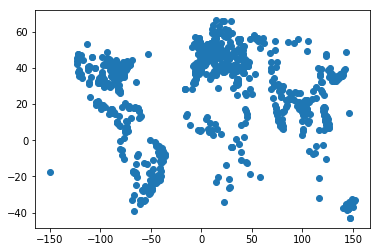

In [168]:
result = %sql SELECT longitude,latitude FROM geonames ORDER BY population DESC LIMIT 1000;
data = np.array(result)
x, y = data.T

plt.scatter(x,y)
plt.show()

# In the second part your job is to work with JSON data from the magic schema. The schema is based on the game Magic: The gathering

## A. Find all the cards that is made by Rob Alexander

In [175]:
%sql SELECT data FROM cards WHERE data @> '{"artist":"Rob Alexander"}' limit 10

10 rows affected.


data
"{'id': '4a7bf234af44e07d9a159d4d89e96ce320919917', 'cmc': 6, 'name': 'Beacon of Immortality', 'text': ""Double target player's life total. Shuffle Beacon of Immortality into its owner's library."", 'type': 'Instant', 'types': ['Instant'], 'artist': 'Rob Alexander', 'colors': ['White'], 'flavor': 'The cave floods with light. A thousand rays shine forth and meld into one.', 'layout': 'normal', 'number': '10', 'rarity': 'Rare', 'manaCost': '{5}{W}', 'imageName': 'beacon of immortality', 'mciNumber': '10', 'multiverseid': 130553, 'colorIdentity': ['W']}"
"{'id': '9cea331c080c3bbc7987c6560f65e39e9d1ed34f', 'cmc': 5, 'name': 'Kavu Climber', 'text': 'When Kavu Climber enters the battlefield, draw a card.', 'type': 'Creature — Kavu', 'power': '3', 'types': ['Creature'], 'artist': 'Rob Alexander', 'colors': ['Green'], 'flavor': '""There was a crack of branches, a rustle of leaves, then a tremendous roar. Our party had no chance as death descended from above.""\n—Taseen, elvish bard', 'layout': 'normal', 'number': '273', 'rarity': 'Common', 'manaCost': '{3}{G}{G}', 'subtypes': ['Kavu'], 'imageName': 'kavu climber', 'mciNumber': '273', 'toughness': '3', 'multiverseid': 129511, 'colorIdentity': ['G']}"
"{'id': '28cc7c79cca8939fd9661f7abfc6ca453715b75e', 'cmc': 0, 'name': 'Llanowar Wastes', 'text': '{T}: Add {C} to your mana pool.\n{T}: Add {B} or {G} to your mana pool. Llanowar Wastes deals 1 damage to you.', 'type': 'Land', 'types': ['Land'], 'artist': 'Rob Alexander', 'layout': 'normal', 'number': '355', 'rarity': 'Rare', 'imageName': 'llanowar wastes', 'mciNumber': '355', 'multiverseid': 129627, 'colorIdentity': ['B', 'G']}"
"{'id': '7a90b7ba6197f8774ed99ecf75ac9abb3e0c0f20', 'cmc': 0, 'name': 'Shivan Reef', 'text': '{T}: Add {C} to your mana pool.\n{T}: Add {U} or {R} to your mana pool. Shivan Reef deals 1 damage to you.', 'type': 'Land', 'types': ['Land'], 'artist': 'Rob Alexander', 'layout': 'normal', 'number': '357', 'rarity': 'Rare', 'imageName': 'shivan reef', 'mciNumber': '357', 'multiverseid': 129731, 'colorIdentity': ['U', 'R']}"
"{'id': '8d1035f151615c949d0645b70fe01d8ab4a3f796', 'cmc': 0, 'name': 'Sulfurous Springs', 'text': '{T}: Add {C} to your mana pool.\n{T}: Add {B} or {R} to your mana pool. Sulfurous Springs deals 1 damage to you.', 'type': 'Land', 'types': ['Land'], 'artist': 'Rob Alexander', 'layout': 'normal', 'number': '359', 'rarity': 'Rare', 'imageName': 'sulfurous springs', 'mciNumber': '359', 'multiverseid': 129751, 'colorIdentity': ['B', 'R']}"
"{'id': 'c97103ab834aad9b3fb7d07c4fb563089f97fe87', 'cmc': 0, 'name': 'Treetop Village', 'text': ""Treetop Village enters the battlefield tapped.\n{T}: Add {G} to your mana pool.\n{1}{G}: Treetop Village becomes a 3/3 green Ape creature with trample until end of turn. It's still a land. (If it would assign enough damage to its blockers to destroy them, you may have it assign the rest of its damage to defending player or planeswalker.)"", 'type': 'Land', 'types': ['Land'], 'artist': 'Rob Alexander', 'layout': 'normal', 'number': '361', 'rarity': 'Uncommon', 'imageName': 'treetop village', 'mciNumber': '361', 'multiverseid': 106455, 'colorIdentity': ['G']}"
"{'id': '24a47bf9cb4596246501294e7127bf74e082bc1d', 'cmc': 0, 'name': 'Plains', 'type': 'Basic Land — Plains', 'types': ['Land'], 'artist': 'Rob Alexander', 'layout': 'normal', 'number': '364', 'rarity': 'Basic Land', 'subtypes': ['Plains'], 'imageName': 'plains1', 'watermark': 'White', 'supertypes': ['Basic'], 'variations': [129682, 129683, 129681], 'multiverseid': 129680, 'colorIdentity': ['W']}"
"{'id': 'be5e30798e4f8b9b6f6e6a8dd2e30bf86bb04b94', 'cmc': 0, 'name': 'Forest', 'type': 'Basic Land — Forest', 'types': ['Land'], 'artist': 'Rob Alexander', 'layout': 'normal', 'number': '382', 'rarity': 'Basic Land', 'subtypes': ['Forest'], 'imageName': 'forest3', 'watermark': 'Green', 'supertypes': ['Basic'], 'variations': [129559, 129562, 129560], 'multiverseid': 129561, 'colorIdentity': ['G']}"
"{'id': '4c3d9f2b708

## B. Find all the cards that have the subtype "Human"

In [176]:
%sql SELECT data FROM cards WHERE data-> 'subtypes' @> '"Human"' limit 10

10 rows affected.


data
"{'id': 'ab1ab474019e4e76c66e2b524d354cb7c3212616', 'cmc': 7, 'name': ""Ancestor's Chosen"", 'text': ""First strike (This creature deals combat damage before creatures without first strike.)\nWhen Ancestor's Chosen enters the battlefield, you gain 1 life for each card in your graveyard."", 'type': 'Creature — Human Cleric', 'power': '4', 'types': ['Creature'], 'artist': 'Pete Venters', 'colors': ['White'], 'flavor': '""The will of all, by my hand done.""', 'layout': 'normal', 'number': '1', 'rarity': 'Uncommon', 'manaCost': '{5}{W}{W}', 'subtypes': ['Human', 'Cleric'], 'imageName': ""ancestor's chosen"", 'mciNumber': '1', 'toughness': '4', 'multiverseid': 130550, 'colorIdentity': ['W']}"
"{'id': 'd3488c0a916bd922856473155a8b49ec23fc2217', 'cmc': 4, 'name': 'Ballista Squad', 'text': '{X}{W}, {T}: Ballista Squad deals X damage to target attacking or blocking creature.', 'type': 'Creature — Human Rebel', 'power': '2', 'types': ['Creature'], 'artist': 'Matthew D. Wilson', 'colors': ['White'], 'flavor': 'The perfect antidote for a tightly packed formation.', 'layout': 'normal', 'number': '8', 'rarity': 'Uncommon', 'manaCost': '{3}{W}', 'subtypes': ['Human', 'Rebel'], 'imageName': 'ballista squad', 'mciNumber': '8', 'toughness': '2', 'multiverseid': 129477, 'colorIdentity': ['W']}"
"{'id': '29c46fca29e5de01dba3bbf05393325bc9132735', 'cmc': 3, 'name': 'Benalish Knight', 'text': 'Flash (You may cast this spell any time you could cast an instant.)\nFirst strike (This creature deals combat damage before creatures without first strike.)', 'type': 'Creature — Human Knight', 'power': '2', 'types': ['Creature'], 'artist': 'Zoltan Boros & Gabor Szikszai', 'colors': ['White'], 'flavor': '""We called them \'armored lightning.\'""\n—Gerrard of the Weatherlight', 'layout': 'normal', 'number': '11', 'rarity': 'Common', 'manaCost': '{2}{W}', 'subtypes': ['Human', 'Knight'], 'imageName': 'benalish knight', 'mciNumber': '11', 'toughness': '2', 'multiverseid': 136279, 'colorIdentity': ['W']}"
"{'id': 'e8b8dea65daf4e9070cce5de62bdbea0bf36d47c', 'cmc': 4, 'name': 'Cho-Manno, Revolutionary', 'text': 'Prevent all damage that would be dealt to Cho-Manno, Revolutionary.', 'type': 'Legendary Creature — Human Rebel', 'power': '2', 'types': ['Creature'], 'artist': 'Steven Belledin', 'colors': ['White'], 'flavor': '""Mercadia\'s masks can no longer hide the truth. Our day has come at last.""', 'layout': 'normal', 'number': '12', 'rarity': 'Rare', 'manaCost': '{2}{W}{W}', 'subtypes': ['Human', 'Rebel'], 'imageName': 'cho-manno, revolutionary', 'mciNumber': '12', 'toughness': '2', 'supertypes': ['Legendary'], 'multiverseid': 130554, 'colorIdentity': ['W']}"
"{'id': '80a6b907fc380ed97615e8abc0fe6071c4ceef67', 'cmc': 3, 'name': 'Field Marshal', 'text': 'Other Soldier creatures get +1/+1 and have first strike. (They deal combat damage before creatures without first strike.)', 'type': 'Creature — Human Soldier', 'power': '2', 'types': ['Creature'], 'artist': 'Stephen Tappin', 'colors': ['White'], 'flavor': 'He is the only one who sees the patterns in the overlapping maps and conflicting reports.', 'layout': 'normal', 'number': '15', 'rarity': 'Rare', 'manaCost': '{1}{W}{W}', 'subtypes': ['Human', 'Soldier'], 'imageName': 'field marshal', 'mciNumber': '15', 'toughness': '2', 'multiverseid': 135258, 'colorIdentity': ['W']}"
"{'id': '7879b835a2c3d6516515d03bd3a3894dceee1812', 'cmc': 1, 'name': 'Honor Guard', 'text': '{W}: Honor Guard gets +0/+1 until end of turn.', 'type': 'Creature — Human Soldier', 'power': '1', 'types': ['Creature'], 'artist': 'Dan Dos Santos', 'colors': ['White'], 'flavor': 'The strength of one. The courage of ten.', 'layout': 'normal', 'number': '23', 'rarity': 'Common', 'manaCost': '{W}', 'subtypes': ['Human', 'Soldier'], 'imageName': 'honor guard', 'mciNumber': '23', 'toughness': '1', 'multiverseid': 129595, 'colorIdentity': ['W']}"
"{'id': '55932565b6905650e67e784b7cf0df63990e9851', 'cmc': 1, 'name': 'Icatian Priest', 'text': '{1}{W}{W}: T

## C. Group all the cards based on the colour. Aggregate them by counting the number of cards per colour.

In [150]:
%%sql select count(*), data::jsonb->'colors' as "color_combinations" from cards
group by data::jsonb->'colors'

32 rows affected.


count,color_combinations
7391,None
54,"['White', 'Red', 'Green']"
24,"['Blue', 'Black', 'Green']"
28,"['White', 'Black', 'Green']"
37,"['White', 'Blue', 'Black', 'Red', 'Green']"
33,"['White', 'Black', 'Red']"
22,"['White', 'Blue', 'Red']"
25,"['Blue', 'Red', 'Green']"
4858,['Red']
174,"['White', 'Black']"


In [156]:
%%sql 
select count(*), jsonb_array_elements(data::jsonb->'colors') as "color" from cards 
group by jsonb_array_elements(data::jsonb->'colors')

5 rows affected.


count,color
6067,Black
5836,Blue
6162,Green
6054,Red
5920,White


In [159]:
cardsResult1 = %sql select count(*), jsonb_array_elements(data::jsonb->'colors') as "color" from cards group by jsonb_array_elements(data::jsonb->'colors')

5 rows affected.


This first bar-chart counts all the colors of the cards. Some cards have more than one color but all colors are counted here.

<Container object of 5 artists>

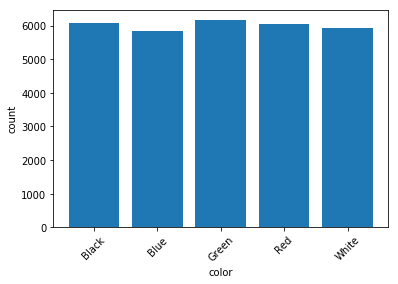

In [166]:
cardsResult1.bar()

In [157]:
cardsResult2 = %sql select count(*), data::jsonb->'colors' as "color_combinations" from cards group by data::jsonb->'colors'

32 rows affected.


This bar-chart counts all unique combinations of colors. Here you can see that many cards have no colors. You can also see that some color combinations are very common and some very rare. 

<Container object of 32 artists>

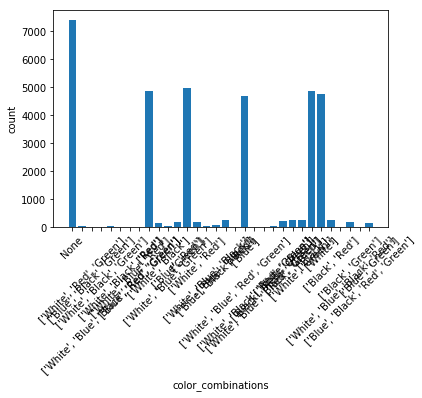

In [158]:
cardsResult2.bar()